### EXP: Beta2 QC rating 

- **Aim:** Second attempt of assesing quality control (QC) of brain registration on the Zooniverse platform. Raters are some of zooniverse users who agreed to test new projects and give feedback ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 100 anatomical brain images (?? OK, ?? Maybe and ?? Fail)   preprocced with NIAK pipelines from ADHD200 and COBRE datsets.
    - We asked raters on the Zooniverse platform to QC images based on the tutorial and the rated sample images.

In [1]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [3]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

In [4]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [5]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [6]:
# List all workflows 
classifications.workflow_name.unique()

array(['Spot anatomical differences', 'Spot functional differences',
       'anat_internal_rating_pierre', 'anat_internal_rating_yassine',
       'Training Session', 'Basile', 'Benjamin', 'Maxime', 'Angela',
       'Sara', 'Pierre_func_rate_1', 'Pierre_anat_rate1',
       'Yassine_func_rate_1', 'Pierre_func_rate_2', 'Start Project',
       'Start Project 1', 'Expert Project 1', 'Expert Project 2',
       'Start Project 2'], dtype=object)

In [7]:
# Filter out only specific workflow
ratings = classifications.loc[classifications['workflow_name'].isin(['Start Project'])]
ratings.count()

classification_id    755
user_name            755
user_id              653
user_ip              755
workflow_id          755
workflow_name        755
workflow_version     755
created_at           755
gold_standard          0
expert                 0
metadata             755
annotations          755
subject_data         755
subject_ids          755
dtype: int64

In [8]:
ratings.subject_ids.loc[2892]

10664112

In [9]:
ratings.subject_data.loc[2892]

{'10664112': {'image1': 'X_3169448_anat.png',
  'image2': 'anat_template_stereotaxic.png',
  'retired': {'classifications_count': 1,
   'created_at': '2017-07-05T18:48:48.783Z',
   'id': 7407615,
   'retired_at': '2017-07-05T18:48:48.818Z',
   'retirement_reason': 'classification_count',
   'subject_id': 10664112,
   'updated_at': '2017-07-05T18:48:48.831Z',
   'workflow_id': 4542},
  'subject_ID': 'X3169448'}}

In [10]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in ratings.annotations]
# extract rating count
ratings.loc[:,"rating"] = [ q[1]['value'] for q in ratings.annotations]
# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['subject_ID'] for ind,row in ratings.iterrows()]
# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['image1'] for ind,row in ratings.iterrows()]

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count

equidad1                              104
Notkabene                             101
rubyadeline                           100
Neuromarq                              49
Janet616                               35
Twieden                                35
Kay_scor4                              34
not-logged-in-41a5e3903be6e17ac6ce     32
Yassinebha                             21
not-logged-in-1c97495d9832e35ff5b9     17
greggk                                 15
LauraThoegersen                        14
CellularPeptide                        13
Joface                                 12
desertfoxx                             11
H_Spiers                               10
AlphaPrime                             10
not-logged-in-0340e5902a57e4ec50d7     10
Keira_stargazer                         9
dme2                                    9
BernieKdy                               9
mayamama                                8
not-logged-in-16af1c7a34aaed6b2076      8
not-logged-in-6bc44518eb932f690a3a

In [12]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>=10]
user_count[list_user]

equidad1                              104
Notkabene                             101
rubyadeline                           100
Neuromarq                              49
Janet616                               35
Twieden                                35
Kay_scor4                              34
not-logged-in-41a5e3903be6e17ac6ce     32
Yassinebha                             21
not-logged-in-1c97495d9832e35ff5b9     17
greggk                                 15
LauraThoegersen                        14
CellularPeptide                        13
Joface                                 12
desertfoxx                             11
H_Spiers                               10
AlphaPrime                             10
not-logged-in-0340e5902a57e4ec50d7     10
Name: user_name, dtype: int64

In [13]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
# Drop my test ratings (yassinebha)
mask = [x.user_name != 'Yassinebha' for ind,x in ratings.iterrows()]
ratings = ratings[mask]
ratings.count()

classification_id    602
user_name            602
user_id              543
user_ip              602
workflow_id          602
workflow_name        602
workflow_version     602
created_at           602
gold_standard          0
expert                 0
metadata             602
annotations          602
subject_data         602
subject_ids          602
n_tagging            602
rating               602
ID                   602
imgnm                602
dtype: int64

In [14]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

not-logged-in-41a5e3903be6e17ac6ce have 2 duplicated ratings
Notkabene have 1 duplicated ratings
equidad1 have 4 duplicated ratings
not-logged-in-1c97495d9832e35ff5b9 have 2 duplicated ratings
Neuromarq have 1 duplicated ratings
Total number of duplicated ratings  = 10


In [15]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

rubyadeline                           100
Notkabene                             100
equidad1                              100
Neuromarq                              48
Janet616                               35
Twieden                                35
Kay_scor4                              34
not-logged-in-41a5e3903be6e17ac6ce     30
greggk                                 15
not-logged-in-1c97495d9832e35ff5b9     15
LauraThoegersen                        14
CellularPeptide                        13
Joface                                 12
desertfoxx                             11
AlphaPrime                             10
H_Spiers                               10
not-logged-in-0340e5902a57e4ec50d7     10
Name: user_name, dtype: int64

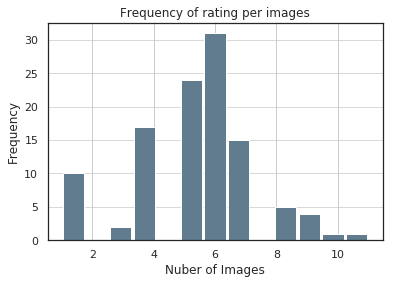

In [16]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [17]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,rubyadeline,Notkabene,equidad1,Neuromarq,Janet616,Twieden,Kay_scor4,not-logged-in-41a5e3903be6e17ac6ce,greggk,not-logged-in-1c97495d9832e35ff5b9,LauraThoegersen,CellularPeptide,Joface,desertfoxx,AlphaPrime,H_Spiers,not-logged-in-0340e5902a57e4ec50d7
0,HC0040062,OK,OK,Maybe,OK,Maybe,OK,Fail,NaN,NaN,NaN,NaN,NaN,NaN,Maybe,OK,NaN,OK
1,X0010125,OK,Maybe,Maybe,NaN,Maybe,NaN,OK,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,X2443191,OK,Maybe,OK,NaN,NaN,NaN,NaN,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HC0040058,Maybe,OK,OK,OK,Maybe,OK,NaN,OK,NaN,NaN,NaN,NaN,NaN,NaN,OK,NaN,OK
4,X0021046,Fail,Fail,Fail,NaN,NaN,Fail,NaN,NaN,NaN,NaN,NaN,NaN,Fail,NaN,Fail,NaN,NaN


In [18]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [19]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,HC0040062,1,3,6
1,X0010125,0,3,3
2,X2443191,0,1,3
3,HC0040058,0,2,7
4,X0021046,6,0,0


In [42]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate
df_norm.head()

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,HC0040062,0.1,0.3,0.6,0.600000,OK
1,X0010125,0,0.5,0.5,0.500000,Maybe
2,X2443191,0,0.25,0.75,0.750000,OK
3,HC0040058,0,0.222222,0.777778,0.777778,OK
4,X0021046,1,0,0,1.000000,Fail


Text(0, 0.5, 'Concensus rating')

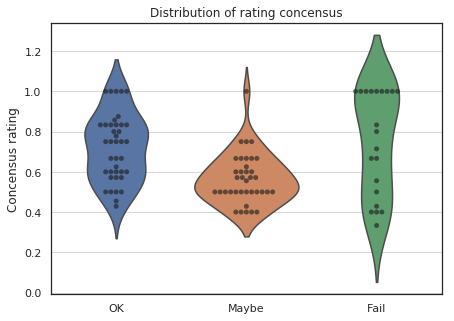

In [43]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')

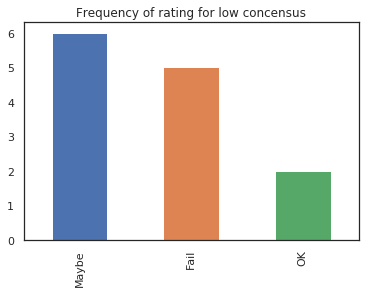

In [44]:
count_ = df_norm.concensus_NoExp[[0 <= row.max_value_NoExp < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

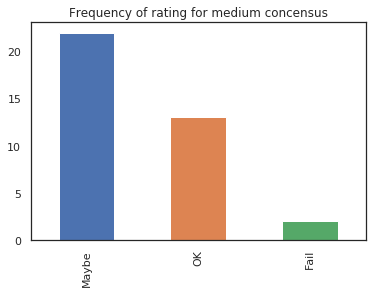

In [45]:
count_ = df_norm.concensus_NoExp[[0.5 <= row.max_value_NoExp < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

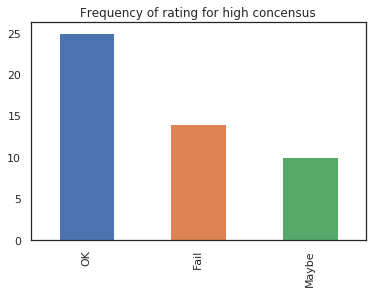

In [46]:
count_ = df_norm.concensus_NoExp[[0.6 < row.max_value_NoExp <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

### Merge Pilot3 and Beta2 rating and get Kappa score

In [144]:
pilot3 = pd.read_csv('../data/rating/Pilot3_internal_rating.csv')
pilot3.head()

,ID,Yben,Pbel,bpinsard,saradupont,angelatam,hereinlies,benjamindeleener,Cons_P3
0,SZ0040029,OK,Maybe,OK,Maybe,OK,Fail,Maybe,Maybe
1,SZ0040039,OK,OK,Fail,OK,Maybe,OK,OK,OK
2,SZ0040042,OK,OK,Maybe,Maybe,OK,Fail,OK,Maybe
3,SZ0040044,OK,OK,Fail,OK,OK,Maybe,OK,OK
4,SZ0040046,OK,OK,Maybe,Maybe,OK,Maybe,OK,Maybe


In [145]:
# Merge 
merge_ratings = pd.merge(pilot3,df_norm[['ID','concensus_NoExp']],on='ID',how='inner').apply(lambda x: x.str.strip() if x.dtype == "object" else x)
merge_ratings.rename(columns={'concensus_NoExp':'Cons_B2'},inplace=True)
merge_ratings

,ID,Yben,Pbel,bpinsard,saradupont,angelatam,hereinlies,benjamindeleener,Cons_P3,Cons_B2
0,X0026002,Maybe,Maybe,Fail,Fail,Maybe,Maybe,Maybe,Maybe,Maybe
1,X3848511,Maybe,Maybe,Fail,Maybe,Maybe,Maybe,Maybe,Maybe,Maybe
2,X3107623,OK,OK,OK,Maybe,Maybe,Maybe,Fail,Maybe,OK
3,X3433846,Maybe,Maybe,Fail,Fail,Maybe,OK,Fail,Fail,Maybe
4,X3163200,Maybe,OK,Fail,OK,Maybe,Fail,Maybe,Fail,Fail
5,X2876903,Maybe,Maybe,Fail,Maybe,Maybe,Maybe,Fail,Maybe,OK
6,X2768273,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail
7,X2409220,Maybe,Maybe,Fail,Fail,Fail,Fail,Maybe,Fail,OK
8,X1536593,Maybe,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail
9,X0010045,Maybe,OK,Fail,Maybe,Maybe,Fail,OK,Fail,Maybe


In [146]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
merge_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
merge_ratings.rename(columns={'bpinsard':'Bpin',
                              'saradupont':'Sdup',
                              'angelatam':'Atam',
                              'hereinlies':'Mpel',
                              'benjamindeleener':'Bdel'},inplace=True)
merge_ratings = merge_ratings[['ID','Yben','Pbel','Atam','Bdel','Sdup','Mpel','Bpin','Cons_B2']]
merge_ratings.head()

,ID,Yben,Pbel,Atam,Bdel,Sdup,Mpel,Bpin,Cons_B2
0,X0026002,2,2,2,2,3,2,3,2
1,X3848511,2,2,2,2,2,2,3,2
2,X3107623,1,1,2,3,2,2,1,1
3,X3433846,2,2,2,3,3,1,3,2
4,X3163200,2,1,2,2,1,3,3,3


In [147]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [148]:
# Percenteage of agrrement between raters with R package IRR
agree_ = merge_ratings.drop(['ID'],axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 29 
   Raters = 8 
  %-agree = 31 



In [163]:
def kappa_score(k_df ):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            #kappa = metrics.cohen_kappa_score(list(k_df[user1]),list(k_df[user2]))
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
    return k_store, p_store

In [164]:
# Get Kappa score out of all different combination of ratings
kappa_df  = merge_ratings.drop(['ID'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.36 , std : 0.18

 Fleiss' Kappa for m Raters

 Subjects = 29 
   Raters = 8 
    Kappa = 0.34 

        z = 11.9 
  p-value = 0 



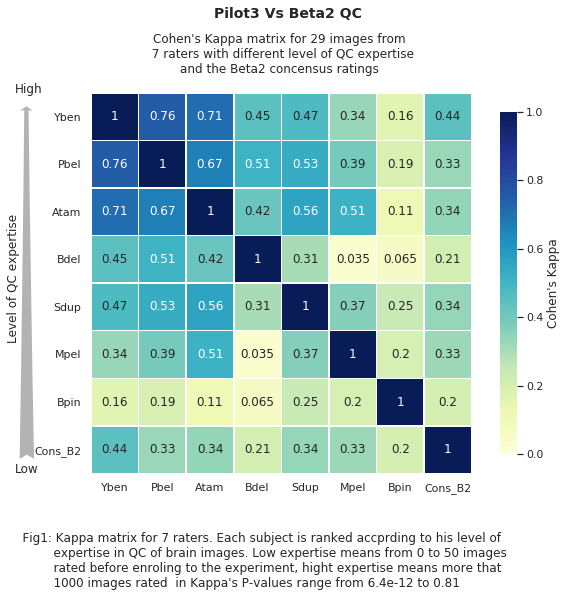

In [165]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (10,7))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot3 Vs Beta2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for {} images from \n  7 raters with different level of QC expertise \n and the Beta2 concensus ratings  ".format(len(merge_ratings)),
               pad=20,fontsize=12)
axes.annotate('Low', xy=(-0.17, 0.97),xytext=(-0.2, -0), xycoords='axes fraction',
              arrowprops=dict(arrowstyle="fancy,tail_width=1.2,head_width=01",
                            fc="0.7", ec="none",
                            linewidth =2))

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters. Each subject is ranked accprding to his level of 
            expertise in QC of brain images. Low expertise means from 0 to 50 images 
            rated before enroling to the experiment, hight expertise means more that 
            1000 images rated  in Kappa's P-values range from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(0.1,-0.1,txt,fontsize=12)
f.text(0.11,0.88,'High',fontsize=12)
f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Pilot3-vs-Beta2_qc.svg')

In [166]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Report tagging from Beta1 raters

In [167]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.user_name.replace({'simexp':'PB','Yassinebha':'YB'},inplace=True)
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X0010061,Start Project,H_Spiers,OK,330.46875,62.0,1.5,2,X_0010061_anat.png,0
1,X0010061,Start Project,H_Spiers,OK,333.46875,288.0,1.5,2,X_0010061_anat.png,0
2,X2232376,Start Project,H_Spiers,OK,NaN,NaN,NaN,0,X_2232376_anat.png,1
3,X3515506,Start Project,H_Spiers,OK,NaN,NaN,NaN,0,X_3515506_anat.png,1
4,X0021014,Start Project,H_Spiers,Fail,333.46875,42.0,1.5,7,X_0021014_anat.png,0


In [168]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm.head()

,ID,imgnm
0,HC0040038,HC0040038_anat.png
1,HC0040043,HC0040043_anat.png
2,HC0040045,HC0040045_anat.png
3,HC0040048,HC0040048_anat.png
4,HC0040050,HC0040050_anat.png


In [169]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)


coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [170]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

### Plot heat map for all tagging

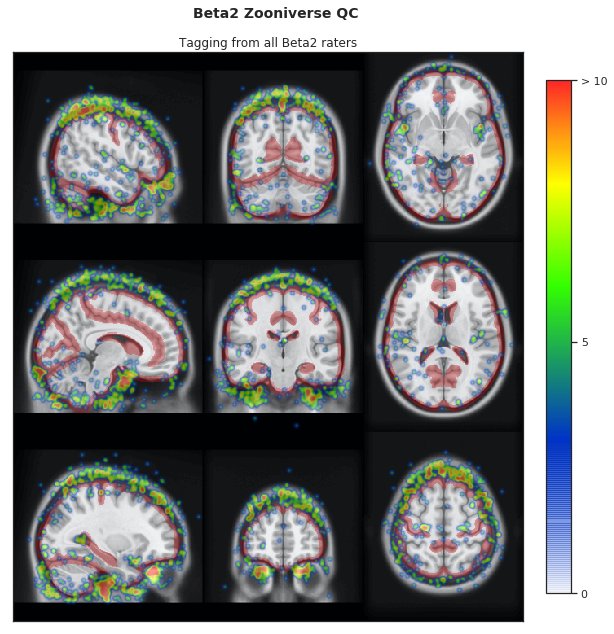

In [171]:
from heatmappy import Heatmapper
from PIL import Image

patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Beta2 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all Beta2 raters')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=10,
                        point_strength = 0.5,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '> 10'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Beta2_qc_heatmap_tags.svg')